In [1]:
# imports 
import numpy as np
import pandas as pd
from math import sqrt 
from pprint import pprint
from numpy import array
from time import time

In [2]:
# load data
import constants
df = pd.read_csv("kddcup.data_10_percent.gz", names = constants.names)

In [3]:
# Categorical features to numeric labels

from sklearn import preprocessing
le_dicts = {}

for categorical_name in constants.categorical_names:
    le = preprocessing.LabelEncoder()
    le.fit(df[categorical_name])
    le_dicts[categorical_name] = dict(zip(le.transform(le.classes_), le.classes_))
    df[categorical_name + '_num'] = le.fit_transform(df[categorical_name])

df['cible'] = df.label.apply(lambda label: 1 if label == 'normal.' else 0)
df['label_four'] = df.label.apply(lambda label: constants.label_to_four_attack_class[label])
df['label_four_num'] = df.label_four.apply(lambda label: constants.five_classes_to_num[label])
df.drop(constants.categorical_names + ['label','label_four_num','label_four'], axis=1, inplace=True)
df.shape

(494021, 42)

In [4]:
# head of data (5)
df.head()

duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        181       5450     0               0       0    0   
1         0        239        486     0               0       0    0   
2         0        235       1337     0               0       0    0   
3         0        219       1337     0               0       0    0   
4         0        217       2032     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...    \
0                  0          1                0  ...     
1                  0          1                0  ...     
2                  0          1                0  ...     
3                  0          1                0  ...     
4                  0          1                0  ...     

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   
1                         0.05                          0.0   
2                         0.03                          0.0   
3                         0.03                          0.0   
4                         0.02                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   
1                   0.0                       0.0                   0.0   
2                   0.0                       0.0                   0.0   
3                   0.0                       0.0                   0.0   
4                   0.0                       0.0                   0.0   

   dst_host_srv_rerror_rate  protocol_type_num  service_num  flag_num  cible  
0                       0.0                  1           22         9      1  
1                       0.0                  1           22         9      1  
2                       0.0                  1           22         9      1  
3                       0.0                  1           22         9      1  
4                       0.0                  1           22         9      1  

[5 rows x 42 columns]

In [5]:
# data to values
df = df.values

In [6]:
# CascadeExtraTrees  
import argparse
import numpy as np
import sys
import pickle
from sklearn.metrics import accuracy_score
sys.path.insert(0, "lib")
from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json
config = load_json("./examples/kdd.json")
gc = GCForest(config)

In [7]:
# train test
from sklearn.cross_validation import train_test_split
y = df[:,41]
X = df[:,0:41]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# count class
len(np.unique(y_train))

2

In [9]:
 # X_enc is the concatenated predict_proba result of CascadeExtraTrees
X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
    

[ 2018-07-30 23:24:00,037][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 41)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 41)],y_test.shape=(163027,)
[ 2018-07-30 23:24:00,100][cascade_classifier.fit_transform] group_dims=[41]
[ 2018-07-30 23:24:00,101][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-30 23:24:00,102][cascade_classifier.fit_transform] group_ends=[41]
[ 2018-07-30 23:24:00,103][cascade_classifier.fit_transform] X_train.shape=(330994, 41),X_test.shape=(163027, 41)
[ 2018-07-30 23:24:00,183][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 41), X_cur_test.shape=(163027, 41)
[ 2018-07-30 23:24:05,596][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.97%
[ 2018-07-30 23:24:11,335][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-30 23:24:16,980][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

In [10]:
# predict
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of CascadeExtraTrees = {:.6f} %".format(acc * 100))
 # Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[ 2018-07-30 23:24:58,404][cascade_classifier.transform] X_groups_test.shape=[(163027, 41)]
[ 2018-07-30 23:24:58,427][cascade_classifier.transform] group_dims=[41]
[ 2018-07-30 23:24:58,428][cascade_classifier.transform] X_test.shape=(163027, 41)
[ 2018-07-30 23:24:58,450][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 41)


Test Accuracy of CascadeExtraTrees = 99.976078 %
[[130829     31]
 [     8  32159]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027



In [11]:
X_train_enc.shape

(330994, 2)

In [12]:
X_test_enc.shape

(163027, 2)

In [13]:
X_train.shape

(330994, 41)

In [14]:
 # predict_proba result of ExtraTrees + data
    
X_test_enc = gc.transform(X_test)
X_train_enc = X_train_enc.reshape((X_train_enc.shape[0], -1))
X_test_enc = X_test_enc.reshape((X_test_enc.shape[0], -1))
X_train_origin = X_train.reshape((X_train.shape[0], -1))
X_test_origin = X_test.reshape((X_test.shape[0], -1))
X_train_enc = np.hstack((X_train_origin, X_train_enc))
X_test_enc = np.hstack((X_test_origin, X_test_enc))

[ 2018-07-30 23:25:02,412][cascade_classifier.transform] X_groups_test.shape=[(163027, 41)]
[ 2018-07-30 23:25:02,436][cascade_classifier.transform] group_dims=[41]
[ 2018-07-30 23:25:02,437][cascade_classifier.transform] X_test.shape=(163027, 41)
[ 2018-07-30 23:25:02,459][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 41)


In [15]:
X_train_new = X_train_enc
X_test_new  = X_test_enc

In [16]:
# Cascade ExtraTrees
config = load_json("./examples/kddgc.json")  
gc = GCForest(config)

X_train=X_train_enc
X_test=X_test_enc 
X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)

[ 2018-07-30 23:25:06,318][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-30 23:25:06,386][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-30 23:25:06,387][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-30 23:25:06,388][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-30 23:25:06,389][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-30 23:25:06,469][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-30 23:25:10,905][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-30 23:25:15,532][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-30 23:25:20,705][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-30 23:28:54,591][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.98%
[ 2018-07-30 23:28:59,305][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.99%
[ 2018-07-30 23:29:04,043][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.98%
[ 2018-07-30 23:29:08,724][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.97%
[ 2018-07-30 23:29:13,445][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.96%
[ 2018-07-30 23:29:18,073][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.97%
[ 2018-07-30 23:29:23,483][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.97%
[ 2018-07-30 23:29:28,808][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.98%


In [17]:
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of CascadeExtraTrees = {:.6f} %".format(acc * 100))
 # Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[ 2018-07-30 23:30:24,583][cascade_classifier.transform] X_groups_test.shape=[(163027, 43)]
[ 2018-07-30 23:30:24,607][cascade_classifier.transform] group_dims=[43]
[ 2018-07-30 23:30:24,608][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-30 23:30:24,631][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)
[ 2018-07-30 23:30:28,642][cascade_classifier.transform] [layer=1] look_indexs=[0], X_cur_test.shape=(163027, 45)
[ 2018-07-30 23:30:32,462][cascade_classifier.transform] [layer=2] look_indexs=[0], X_cur_test.shape=(163027, 45)


Test Accuracy of CascadeExtraTrees = 99.977918 %
[[130843     17]
 [    19  32148]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027



In [18]:
# CascadeExtraTrees
def update(X_train,X_test):
    # update Estimators
    M = np.delete(X_train, (-1), axis=1)
    X_train= np.delete(M, (-1), axis=1)
    M = np.delete(X_test, (-1), axis=1)
    X_test = np.delete(M, (-1), axis=1)
    return X_train,X_test

def newdata(X_test_enc, X_train_enc):
    # Make Data + Estimators
    X_train_origin = X_train.reshape((X_train.shape[0], -1))
    X_test_origin = X_test.reshape((X_test.shape[0], -1))
    X_train_enc = np.hstack((X_train_origin, X_train_enc))
    X_test_enc = np.hstack((X_test_origin, X_test_enc))
    return X_test_enc, X_train_enc

Accuracy = []
def affiche():
    # predict
    y_pred = gc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy of CascadeExtraTrees = {:.6f} %".format(acc * 100),"Layer :",i)
    Accuracy.append(round(acc*100 , 2))
    # Matrix de confusion
    from sklearn.metrics import classification_report, confusion_matrix
    print(confusion_matrix(y_test,y_pred))
    print('\n')
    print(classification_report(y_test,y_pred))   
    
    
# Deep
t = []
for i in range (20):
    t0 = time()
    X_train,X_test=update(X_train,X_test)
    X_test_enc, X_train_enc=newdata(X_test_enc, X_train_enc)

    X_train=X_train_enc
    X_test=X_test_enc 
    
    config = load_json("./examples/kddgc.json")  
    gc = GCForest(config)
    X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test) 
    tt = time() - t0
    affiche() 
    t.append(round(tt,2))
    print (" Time ",format(round(tt,3))," seconds")

[ 2018-07-30 23:30:36,722][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-30 23:30:36,788][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-30 23:30:36,789][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-30 23:30:36,790][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-30 23:30:36,791][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-30 23:30:36,866][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-30 23:30:41,244][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-30 23:30:46,083][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-30 23:30:50,991][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-30 23:34:14,876][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.98%
[ 2018-07-30 23:34:20,016][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.99%
[ 2018-07-30 23:34:26,672][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.98%
[ 2018-07-30 23:34:33,398][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.97%
[ 2018-07-30 23:34:38,426][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-30 23:34:43,299][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.97%
[ 2018-07-30 23:34:48,351][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.97%
[ 2018-07-30 23:34:53,378][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.97%


[ 2018-07-30 23:38:17,322][kfold_wrapper.log_eval_metrics] Accuracy(layer_8 - estimator_0 - 10_folds.train_7.predict)=99.97%
[ 2018-07-30 23:38:22,678][kfold_wrapper.log_eval_metrics] Accuracy(layer_8 - estimator_0 - 10_folds.train_8.predict)=99.99%
[ 2018-07-30 23:38:28,282][kfold_wrapper.log_eval_metrics] Accuracy(layer_8 - estimator_0 - 10_folds.train_9.predict)=99.98%
[ 2018-07-30 23:38:28,658][kfold_wrapper.log_eval_metrics] Accuracy(layer_8 - estimator_0 - 10_folds.train_cv.predict)=99.97%
[ 2018-07-30 23:38:28,661][kfold_wrapper.log_eval_metrics] Accuracy(layer_8 - estimator_0 - 10_folds.test.predict)=99.97%
[ 2018-07-30 23:38:28,668][cascade_classifier.calc_accuracy] Accuracy(layer_8 - train.classifier_average)=99.97%
[ 2018-07-30 23:38:28,671][cascade_classifier.calc_accuracy] Accuracy(layer_8 - test.classifier_average)=99.97%
[ 2018-07-30 23:38:28,760][cascade_classifier.fit_transform] [layer=9] look_indexs=[0], X_cur_train.shape=(330994, 45), X_cur_test.shape=(163027, 45)
[ 

('Test Accuracy of CascadeExtraTrees = 99.976078 %', 'Layer :', 0)
[[130842     18]
 [    21  32146]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '522.908', ' seconds')


[ 2018-07-30 23:39:48,168][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-30 23:39:48,233][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-30 23:39:48,234][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-30 23:39:48,234][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-30 23:39:48,235][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-30 23:39:48,308][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-30 23:39:52,780][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-30 23:39:57,815][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-30 23:40:02,936][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-30 23:43:40,537][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-30 23:43:45,970][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.99%
[ 2018-07-30 23:43:51,238][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.98%
[ 2018-07-30 23:43:56,466][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-30 23:44:01,915][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.96%
[ 2018-07-30 23:44:06,761][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.97%
[ 2018-07-30 23:44:12,100][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-30 23:44:17,336][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.98%


('Test Accuracy of CascadeExtraTrees = 99.974237 %', 'Layer :', 1)
[[130840     20]
 [    22  32145]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '391.603', ' seconds')


[ 2018-07-30 23:46:39,712][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-30 23:46:39,780][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-30 23:46:39,781][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-30 23:46:39,781][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-30 23:46:39,782][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-30 23:46:39,858][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-30 23:46:44,576][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-30 23:46:50,808][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-30 23:46:56,289][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-30 23:50:36,002][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-30 23:50:41,497][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.99%
[ 2018-07-30 23:50:48,642][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-30 23:50:56,376][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.97%
[ 2018-07-30 23:51:01,528][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.96%
[ 2018-07-30 23:51:06,391][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-30 23:51:11,675][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-30 23:51:18,572][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.98%


('Test Accuracy of CascadeExtraTrees = 99.975464 %', 'Layer :', 2)
[[130839     21]
 [    19  32148]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '408.02', ' seconds')


[ 2018-07-30 23:53:44,122][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-30 23:53:44,186][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-30 23:53:44,187][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-30 23:53:44,188][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-30 23:53:44,189][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-30 23:53:44,261][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-30 23:53:48,865][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-30 23:53:53,881][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-30 23:53:59,203][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-30 23:57:44,792][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.98%
[ 2018-07-30 23:57:50,232][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.99%
[ 2018-07-30 23:57:55,543][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-30 23:58:02,650][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-30 23:58:08,880][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-30 23:58:14,674][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-30 23:58:21,434][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-30 23:58:29,931][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.97%


('Test Accuracy of CascadeExtraTrees = 99.974237 %', 'Layer :', 3)
[[130839     21]
 [    21  32146]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '465.439', ' seconds')


[ 2018-07-31 00:01:51,688][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:01:51,753][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:01:51,754][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:01:51,755][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:01:51,756][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:01:51,829][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:01:56,558][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 00:02:01,780][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:02:07,347][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:05:57,561][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-31 00:06:03,171][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.98%
[ 2018-07-31 00:06:11,931][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 00:06:18,678][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.97%
[ 2018-07-31 00:06:24,229][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 00:06:29,609][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-31 00:06:36,143][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 00:06:42,592][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.973624 %', 'Layer :', 4)
[[130837     23]
 [    20  32147]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '362.523', ' seconds')


[ 2018-07-31 00:08:06,125][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:08:06,193][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:08:06,194][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:08:06,195][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:08:06,196][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:08:06,271][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:08:12,569][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 00:08:19,946][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:08:25,987][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:12:03,542][cascade_classifier.transform] group_dims=[43]
[ 2018-07-31 00:12:03,543][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-31 00:12:03,565][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)


('Test Accuracy of CascadeExtraTrees = 99.975464 %', 'Layer :', 5)
[[130835     25]
 [    15  32152]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '237.641', ' seconds')


[ 2018-07-31 00:12:07,833][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:12:07,897][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:12:07,898][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:12:07,899][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:12:07,900][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:12:07,972][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:12:12,564][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-31 00:12:17,751][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:12:25,091][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:16:09,962][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-31 00:16:15,509][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.98%
[ 2018-07-31 00:16:20,908][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.96%
[ 2018-07-31 00:16:28,126][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.96%
[ 2018-07-31 00:16:34,568][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 00:16:39,725][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-31 00:16:45,462][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 00:16:51,020][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.968717 %', 'Layer :', 6)
[[130824     36]
 [    15  32152]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '346.518', ' seconds')


[ 2018-07-31 00:18:06,248][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:18:06,316][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:18:06,317][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:18:06,318][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:18:06,318][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:18:06,394][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:18:11,282][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 00:18:16,824][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:18:22,696][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:22:05,892][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-31 00:22:11,451][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.98%
[ 2018-07-31 00:22:17,101][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 00:22:23,237][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.97%
[ 2018-07-31 00:22:30,560][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 00:22:36,226][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-31 00:22:42,079][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 00:22:47,607][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.974851 %', 'Layer :', 7)
[[130834     26]
 [    15  32152]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '403.488', ' seconds')


[ 2018-07-31 00:25:05,494][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:25:05,558][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:25:05,559][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:25:05,559][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:25:05,560][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:25:05,632][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:25:10,209][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 00:25:15,447][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:25:20,775][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:29:03,214][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.98%
[ 2018-07-31 00:29:08,746][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.98%
[ 2018-07-31 00:29:14,216][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 00:29:19,580][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.97%
[ 2018-07-31 00:29:25,046][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 00:29:29,988][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-31 00:29:35,943][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 00:29:41,828][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.973011 %', 'Layer :', 8)
[[130834     26]
 [    18  32149]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '282.372', ' seconds')


[ 2018-07-31 00:29:55,932][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:29:55,999][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:29:56,000][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:29:56,001][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:29:56,002][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:29:56,076][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:30:00,896][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 00:30:06,338][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-31 00:30:11,694][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:33:40,778][cascade_classifier.transform] group_dims=[43]
[ 2018-07-31 00:33:40,779][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-31 00:33:40,801][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)


('Test Accuracy of CascadeExtraTrees = 99.974851 %', 'Layer :', 9)
[[130836     24]
 [    17  32150]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '225.069', ' seconds')


[ 2018-07-31 00:33:45,088][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:33:45,153][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:33:45,154][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:33:45,155][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:33:45,156][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:33:45,229][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:33:49,798][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-31 00:33:55,017][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:34:00,375][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:37:32,226][cascade_classifier.transform] group_dims=[43]
[ 2018-07-31 00:37:32,227][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-31 00:37:32,250][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)


('Test Accuracy of CascadeExtraTrees = 99.975464 %', 'Layer :', 10)
[[130838     22]
 [    18  32149]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '227.348', ' seconds')


[ 2018-07-31 00:37:37,230][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:37:37,301][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:37:37,302][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:37:37,303][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:37:37,304][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:37:37,386][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:37:42,705][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-31 00:37:48,341][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-31 00:37:53,674][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:41:34,166][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.98%
[ 2018-07-31 00:41:40,360][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.98%
[ 2018-07-31 00:41:46,222][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 00:41:51,846][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-31 00:41:57,299][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 00:42:02,337][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.97%
[ 2018-07-31 00:42:07,864][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 00:42:13,505][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.971170 %', 'Layer :', 11)
[[130833     27]
 [    20  32147]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '453.926', ' seconds')


[ 2018-07-31 00:45:31,016][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:45:31,083][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:45:31,084][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:45:31,085][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:45:31,086][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:45:31,162][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:45:36,556][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-31 00:45:44,999][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:45:50,995][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:49:44,553][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.98%
[ 2018-07-31 00:49:50,164][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.98%
[ 2018-07-31 00:49:55,491][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 00:50:01,053][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-31 00:50:06,701][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 00:50:11,662][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.97%
[ 2018-07-31 00:50:17,214][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.97%
[ 2018-07-31 00:50:23,104][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.974237 %', 'Layer :', 12)
[[130834     26]
 [    16  32151]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '489.593', ' seconds')


[ 2018-07-31 00:54:00,652][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:54:00,719][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:54:00,720][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:54:00,721][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:54:00,721][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:54:00,796][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:54:05,570][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 00:54:10,909][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:54:16,331][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 00:57:55,590][cascade_classifier.transform] group_dims=[43]
[ 2018-07-31 00:57:55,590][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-31 00:57:55,614][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)


('Test Accuracy of CascadeExtraTrees = 99.973624 %', 'Layer :', 13)
[[130837     23]
 [    20  32147]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '235.165', ' seconds')


[ 2018-07-31 00:57:59,903][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 00:57:59,970][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 00:57:59,971][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 00:57:59,971][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 00:57:59,972][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 00:58:00,047][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 00:58:04,700][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 00:58:12,178][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 00:58:18,974][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 01:02:13,170][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-31 01:02:18,784][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.97%
[ 2018-07-31 01:02:26,267][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 01:02:32,138][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-31 01:02:38,106][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 01:02:43,217][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-31 01:02:50,914][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.95%
[ 2018-07-31 01:02:56,627][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.971170 %', 'Layer :', 14)
[[130835     25]
 [    22  32145]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '367.433', ' seconds')


[ 2018-07-31 01:04:19,303][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 01:04:19,370][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 01:04:19,371][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 01:04:19,372][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 01:04:19,373][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 01:04:19,448][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 01:04:24,655][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 01:04:31,696][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 01:04:37,323][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 01:08:37,280][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-31 01:08:43,539][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.98%
[ 2018-07-31 01:08:49,433][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 01:08:55,216][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-31 01:09:00,965][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 01:09:06,116][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-31 01:09:11,746][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 01:09:17,255][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.97%


('Test Accuracy of CascadeExtraTrees = 99.974237 %', 'Layer :', 15)
[[130839     21]
 [    21  32146]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '425.007', ' seconds')


[ 2018-07-31 01:11:41,265][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 01:11:41,332][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 01:11:41,334][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 01:11:41,335][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 01:11:41,336][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 01:11:41,411][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 01:11:46,688][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 01:11:52,005][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 01:11:57,257][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 01:15:35,749][cascade_classifier.transform] group_dims=[43]
[ 2018-07-31 01:15:35,750][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-31 01:15:35,773][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)


('Test Accuracy of CascadeExtraTrees = 99.973011 %', 'Layer :', 16)
[[130836     24]
 [    20  32147]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '234.727', ' seconds')


[ 2018-07-31 01:15:40,662][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 01:15:40,726][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 01:15:40,727][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 01:15:40,728][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 01:15:40,728][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 01:15:40,801][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 01:15:45,877][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.95%
[ 2018-07-31 01:15:51,121][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-31 01:15:56,574][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 01:19:37,553][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-31 01:19:43,689][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.97%
[ 2018-07-31 01:19:49,646][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.97%
[ 2018-07-31 01:19:55,060][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-31 01:20:00,587][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.95%
[ 2018-07-31 01:20:05,726][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.95%
[ 2018-07-31 01:20:11,283][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 01:20:16,832][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.971784 %', 'Layer :', 17)
[[130827     33]
 [    13  32154]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '339.556', ' seconds')


[ 2018-07-31 01:21:32,210][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 01:21:32,277][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 01:21:32,278][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 01:21:32,279][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 01:21:32,280][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 01:21:32,355][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 01:21:37,142][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-31 01:21:42,899][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.95%
[ 2018-07-31 01:21:48,911][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 01:25:16,691][cascade_classifier.transform] group_dims=[43]
[ 2018-07-31 01:25:16,692][cascade_classifier.transform] X_test.shape=(163027, 43)
[ 2018-07-31 01:25:16,714][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(163027, 43)


('Test Accuracy of CascadeExtraTrees = 99.974237 %', 'Layer :', 18)
[[130831     29]
 [    13  32154]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '224.706', ' seconds')


[ 2018-07-31 01:25:21,255][cascade_classifier.fit_transform] X_groups_train.shape=[(330994, 43)],y_train.shape=(330994,),X_groups_test.shape=[(163027, 43)],y_test.shape=(163027,)
[ 2018-07-31 01:25:21,319][cascade_classifier.fit_transform] group_dims=[43]
[ 2018-07-31 01:25:21,321][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-07-31 01:25:21,322][cascade_classifier.fit_transform] group_ends=[43]
[ 2018-07-31 01:25:21,323][cascade_classifier.fit_transform] X_train.shape=(330994, 43),X_test.shape=(163027, 43)
[ 2018-07-31 01:25:21,398][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(330994, 43), X_cur_test.shape=(163027, 43)
[ 2018-07-31 01:25:27,602][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=99.96%
[ 2018-07-31 01:25:33,057][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=99.96%
[ 2018-07-31 01:25:38,397][kfold_wrapper.log_eval_metrics] Accuracy(layer_0

[ 2018-07-31 01:29:19,277][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_1.predict)=99.97%
[ 2018-07-31 01:29:24,954][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_2.predict)=99.97%
[ 2018-07-31 01:29:30,491][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_3.predict)=99.98%
[ 2018-07-31 01:29:36,340][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_4.predict)=99.98%
[ 2018-07-31 01:29:42,156][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_5.predict)=99.97%
[ 2018-07-31 01:29:48,017][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_6.predict)=99.96%
[ 2018-07-31 01:29:53,880][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_7.predict)=99.96%
[ 2018-07-31 01:29:59,403][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_0 - 10_folds.train_8.predict)=99.96%


('Test Accuracy of CascadeExtraTrees = 99.970557 %', 'Layer :', 19)
[[130829     31]
 [    17  32150]]


             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    130860
        1.0       1.00      1.00      1.00     32167

avg / total       1.00      1.00      1.00    163027

(' Time ', '460.358', ' seconds')


('Opt_Cascade_num =', 0, ' Accuracy =', 99.98, 'Time =', 522.90999999999997)


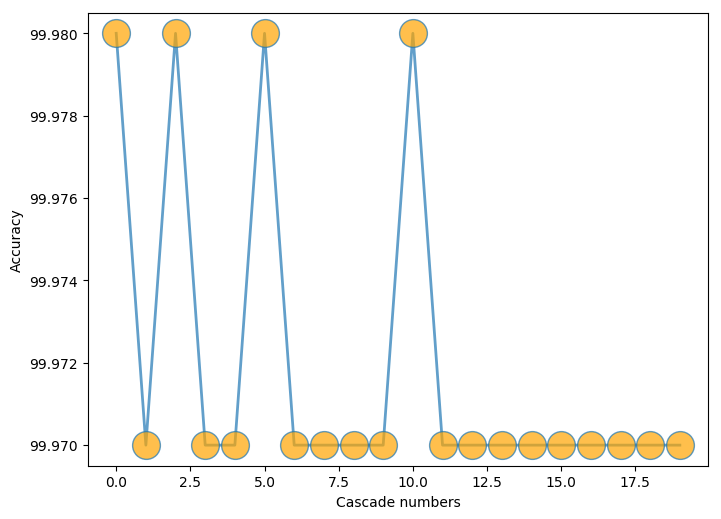

In [19]:
print ("Opt_Cascade_num =",Accuracy.index(max(Accuracy)), " Accuracy =", max(Accuracy) ,
       "Time =" , np.sum(t[0:Accuracy.index(max(Accuracy))+1]))

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
plt.plot(Accuracy, '-o', ms=20, lw=2, alpha=0.7, mfc='orange')
plt.ylabel('Accuracy')
plt.xlabel('Cascade numbers')
plt.show()

In [20]:
Accuracy

[99.98,
 99.97,
 99.98,
 99.97,
 99.97,
 99.98,
 99.97,
 99.97,
 99.97,
 99.97,
 99.98,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97,
 99.97]